# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-05-11*

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [4]:
isam = xr.open_dataset('F:/Data/Project_anqing/April/add_data/April_05wind_ISAM.nc')
isam

<xarray.Dataset>
Dimensions:    (time: 120, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-06 ... 2023-04-10T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    O3_AQ      (time, level, y, x) float32 ...
    O3_HF      (time, level, y, x) float32 ...
    O3_TL      (time, level, y, x) float32 ...
    O3_CZ      (time, level, y, x) float32 ...
    O3_JJ      (time, level, y, x) float32 ...
    O3_OTH     (time, level, y, x) float32 ...
    O3_ICO     (time, level, y, x) float32 ...
    O3_BCO     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [5]:
# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isam.O3_AQ, isam.O3_HF, isam.O3_TL, isam.O3_CZ, 
            isam.O3_JJ, isam.O3_OTH, isam.O3_ICO, isam.O3_BCO]
name_list = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    # L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    L1_dict[f"{name_list[i]}_L1"] = var[:,0,:,:]
    
    # 在 L2 字典中存储 L2 变量
    # L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1 = L1_dict.values()
# AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2 = L2_dict.values()

In [7]:
# 计算区域范围内的平均值
import geopandas as gpd

shpurban = 'F:/Data/Project_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)

for i in range(np.size(isam.latitude,0)):
    for j in range(np.size(isam.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],isam.longitude[i,j],isam.latitude[i,j])==False:
            AQ_L1[:,i,j]=np.nan
            HF_L1[:,i,j]=np.nan
            TL_L1[:,i,j]=np.nan
            CZ_L1[:,i,j]=np.nan
            JJ_L1[:,i,j]=np.nan
            OTH_L1[:,i,j]=np.nan
            ICO_L1[:,i,j]=np.nan
            BCO_L1[:,i,j]=np.nan
            
AQ_L1 = np.nanmean(np.nanmean(AQ_L1,1),1)
HF_L1 = np.nanmean(np.nanmean(HF_L1,1),1)
TL_L1 = np.nanmean(np.nanmean(TL_L1,1),1)
CZ_L1 = np.nanmean(np.nanmean(CZ_L1,1),1)
JJ_L1 = np.nanmean(np.nanmean(JJ_L1,1),1)
OTH_L1 = np.nanmean(np.nanmean(OTH_L1,1),1)
ICO_L1 = np.nanmean(np.nanmean(ICO_L1,1),1)
BCO_L1 = np.nanmean(np.nanmean(BCO_L1,1),1)

In [16]:
chem = xr.open_dataset('F:/Data/Project_anqing/April/April_chem.nc')

start = pd.Timestamp('2023-04-06')
end   = pd.Timestamp('2023-04-10T23')

O3 = chem.O3[:,0,:,:].sel(time=slice(start,end))

for i in range(np.size(chem.latitude,0)):
    for j in range(np.size(chem.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],chem.longitude[i,j],chem.latitude[i,j])==False:
            O3[:,i,j]=np.nan

O3 = np.nanmean(np.nanmean(O3,1),1)

In [19]:
xlsfile = pd.read_excel('F:/Data/Project_anqing/April/obsdata/urban.xlsx',index_col=0)
obs = xlsfile['O3']['2023-04-06':'2023-04-10']
obs.shape

(120,)

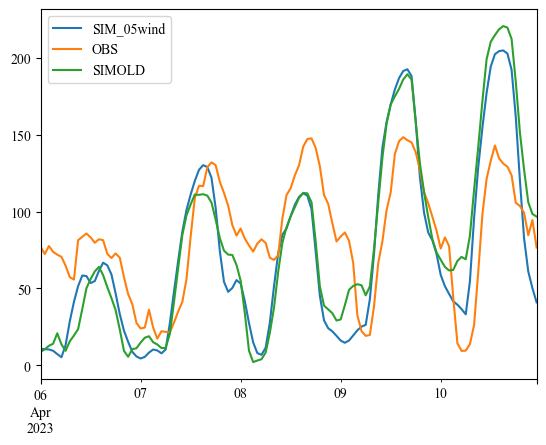

In [22]:
timeindex = pd.date_range('2023-04-06T00','2023-04-10T23',freq='h')

O3_05wind = AQ_L1+HF_L1+TL_L1+CZ_L1+JJ_L1+OTH_L1+ICO_L1+BCO_L1
df = pd.DataFrame(
    index=timeindex,
    data={'SIM_05wind':O3_05wind,
          'OBS':obs.values,
          'SIMOLD':O3,
          }
    )

df.plot()
plt.show()

In [8]:
# 设定变量名称循环列表
names = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO',]

# 计算ratio
ratio_L1 = {}
for name in names:
    var_L1 = f"{name}_L1"
    ratio_L1[f"{var_L1}_rt"] = globals()[var_L1] / O3_05BCO
    
AQ_L1_rt, HF_L1_rt, TL_L1_rt, CZ_L1_rt, JJ_L1_rt, OTH_L1_rt, ICO_L1_rt = ratio_L1.values()

BCO_L1_rt = 0.5*BCO_L1/O3_05BCO

## 画图

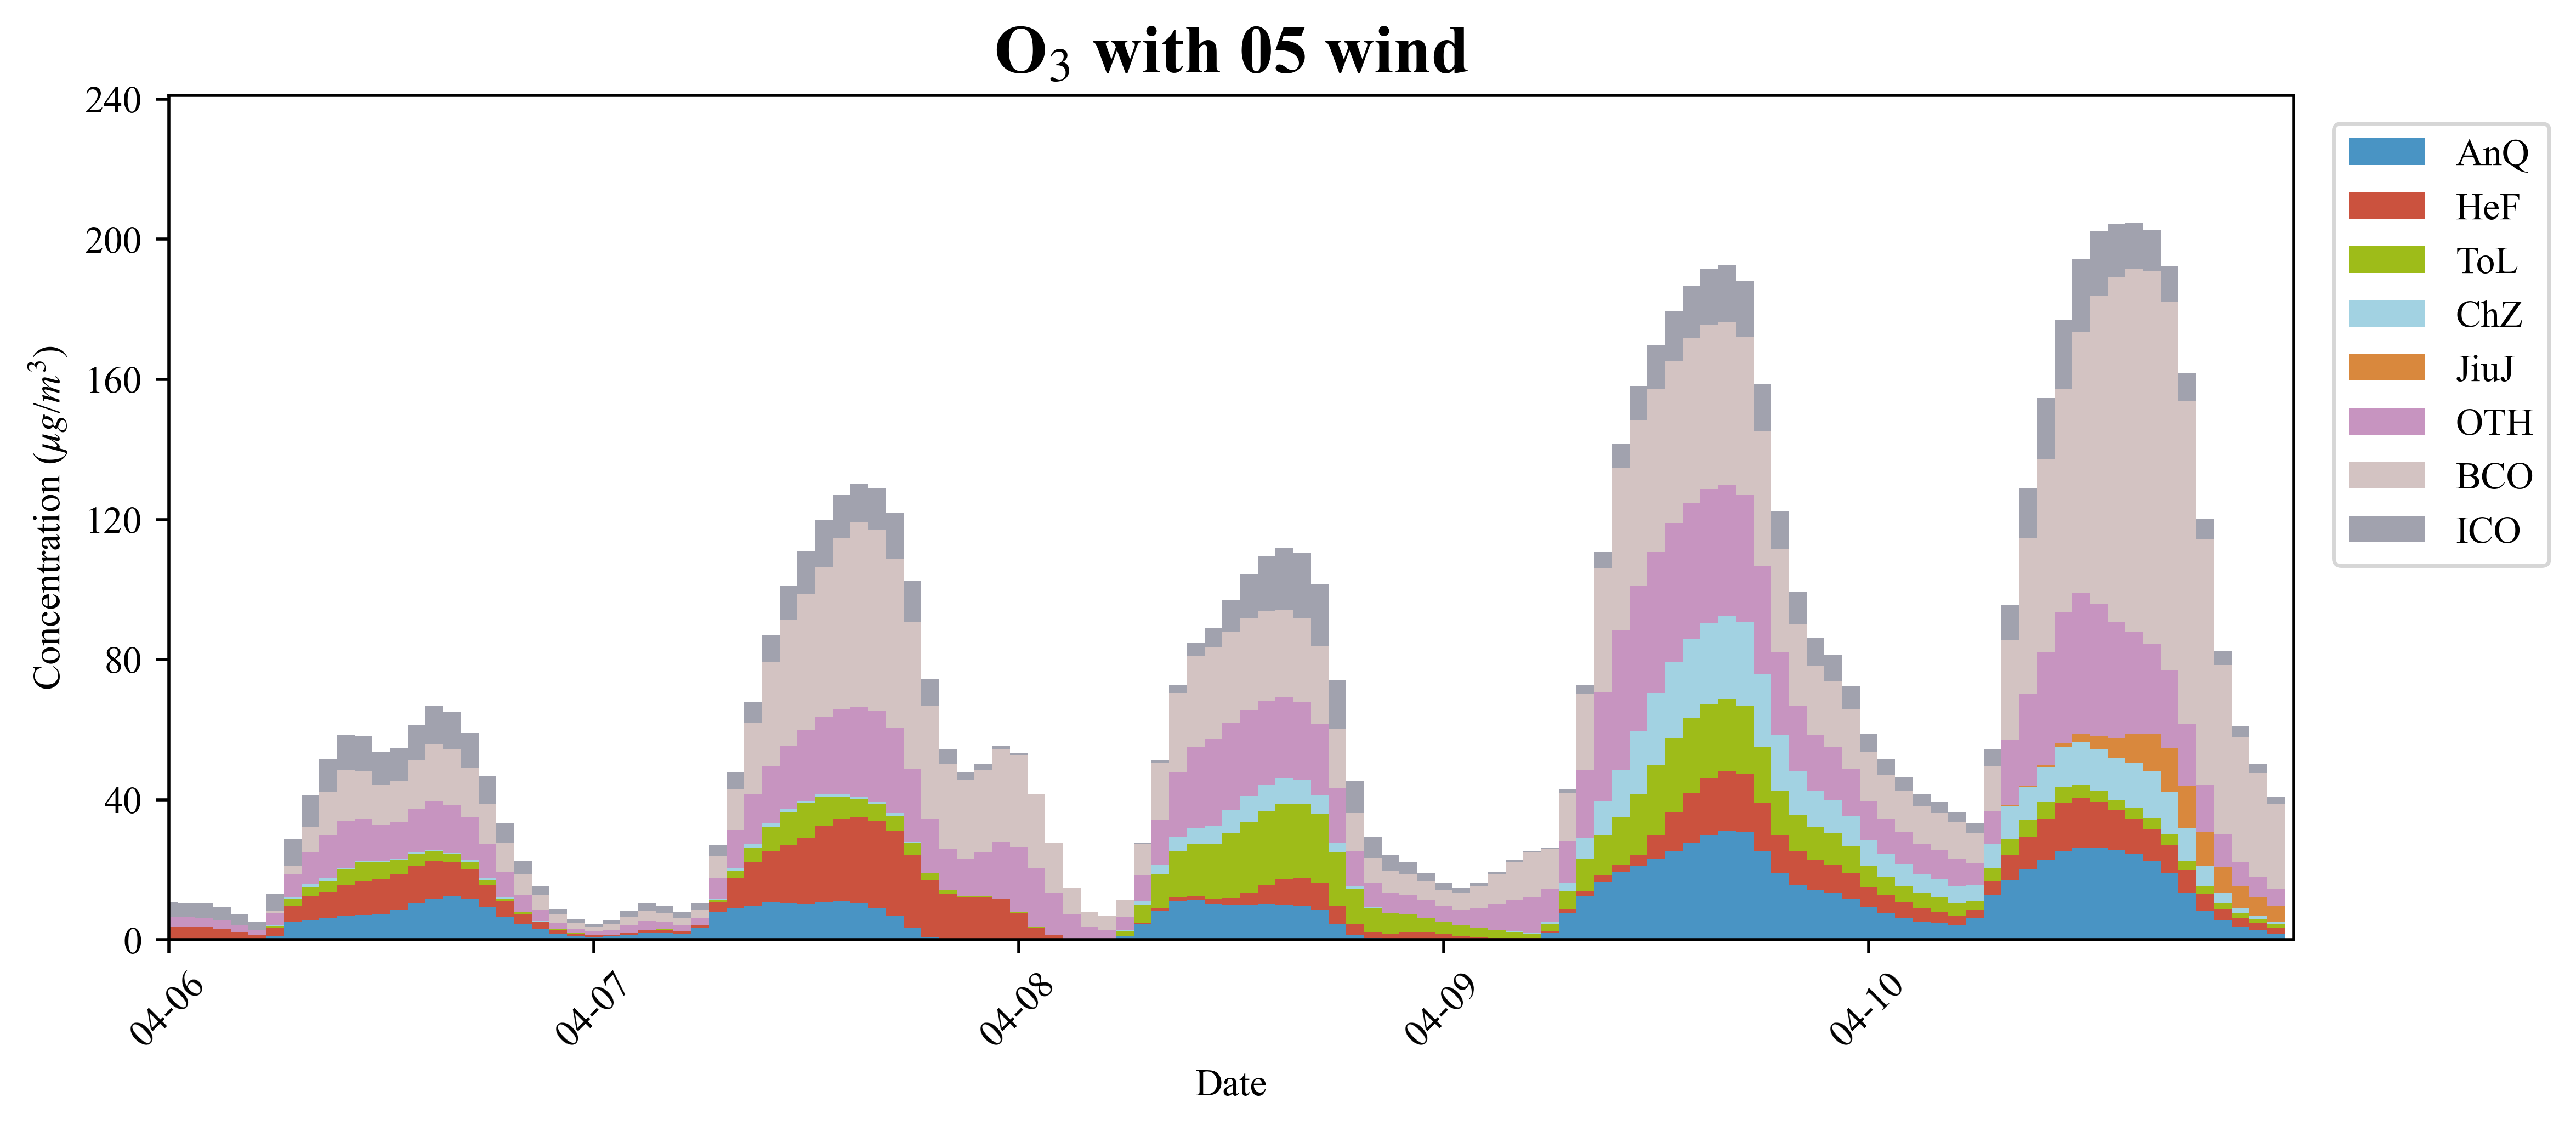

In [35]:
ts=np.arange(0,120)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,AQ_L1,color=coloraq,width=1)
b2=ax.bar(ts,HF_L1,bottom=AQ_L1,color=colorhf,width=1)
b3=ax.bar(ts,TL_L1,bottom=HF_L1+AQ_L1,color=colortl,width=1)
b4=ax.bar(ts,CZ_L1,bottom=TL_L1+HF_L1+AQ_L1,color=colorcz,width=1)
b5=ax.bar(ts,JJ_L1,bottom=CZ_L1+TL_L1+HF_L1+AQ_L1,color=colorjj,width=1)
b6=ax.bar(ts,OTH_L1,bottom=JJ_L1+CZ_L1+TL_L1+HF_L1+AQ_L1,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,BCO_L1,bottom=OTH_L1+JJ_L1+CZ_L1+TL_L1+HF_L1+AQ_L1,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ICO_L1,bottom=BCO_L1+OTH_L1+JJ_L1+CZ_L1+TL_L1+HF_L1+AQ_L1,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ with 05 wind',fontweight='bold',size=18)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,120,24))
ax.set_xticklabels(pd.date_range('2023-04-06','2023-04-10',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,241,40))
# ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,241)
ax.set_xlim(0,120)

plt.show()

In [28]:
isamold = xr.open_dataset('F:/Data/Project_anqing/April/April_ISAM1.nc')

# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isamold.O3_AQ, isamold.O3_HF, isamold.O3_TL, isamold.O3_CZ, 
            isamold.O3_JJ, isamold.O3_OTH, isamold.O3_ICO, isamold.O3_BCO]
name_list = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    # L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    L1_dict[f"{name_list[i]}_L1o"] = var[:,0,:,:].sel(time=slice(start,end))
    
    # 在 L2 字典中存储 L2 变量
    # L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AQ_L1o, HF_L1o, TL_L1o, CZ_L1o, JJ_L1o, OTH_L1o, ICO_L1o, BCO_L1o = L1_dict.values()
# AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2 = L2_dict.values()

In [30]:
for i in range(np.size(isam.latitude,0)):
    for j in range(np.size(isam.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],isam.longitude[i,j],isam.latitude[i,j])==False:
            AQ_L1o[:,i,j]=np.nan
            HF_L1o[:,i,j]=np.nan
            TL_L1o[:,i,j]=np.nan
            CZ_L1o[:,i,j]=np.nan
            JJ_L1o[:,i,j]=np.nan
            OTH_L1o[:,i,j]=np.nan
            ICO_L1o[:,i,j]=np.nan
            BCO_L1o[:,i,j]=np.nan
            
AQ_L1o = np.nanmean(np.nanmean(AQ_L1o,1),1)
HF_L1o = np.nanmean(np.nanmean(HF_L1o,1),1)
TL_L1o = np.nanmean(np.nanmean(TL_L1o,1),1)
CZ_L1o = np.nanmean(np.nanmean(CZ_L1o,1),1)
JJ_L1o = np.nanmean(np.nanmean(JJ_L1o,1),1)
OTH_L1o = np.nanmean(np.nanmean(OTH_L1o,1),1)
ICO_L1o = np.nanmean(np.nanmean(ICO_L1o,1),1)
BCO_L1o = np.nanmean(np.nanmean(BCO_L1o,1),1)

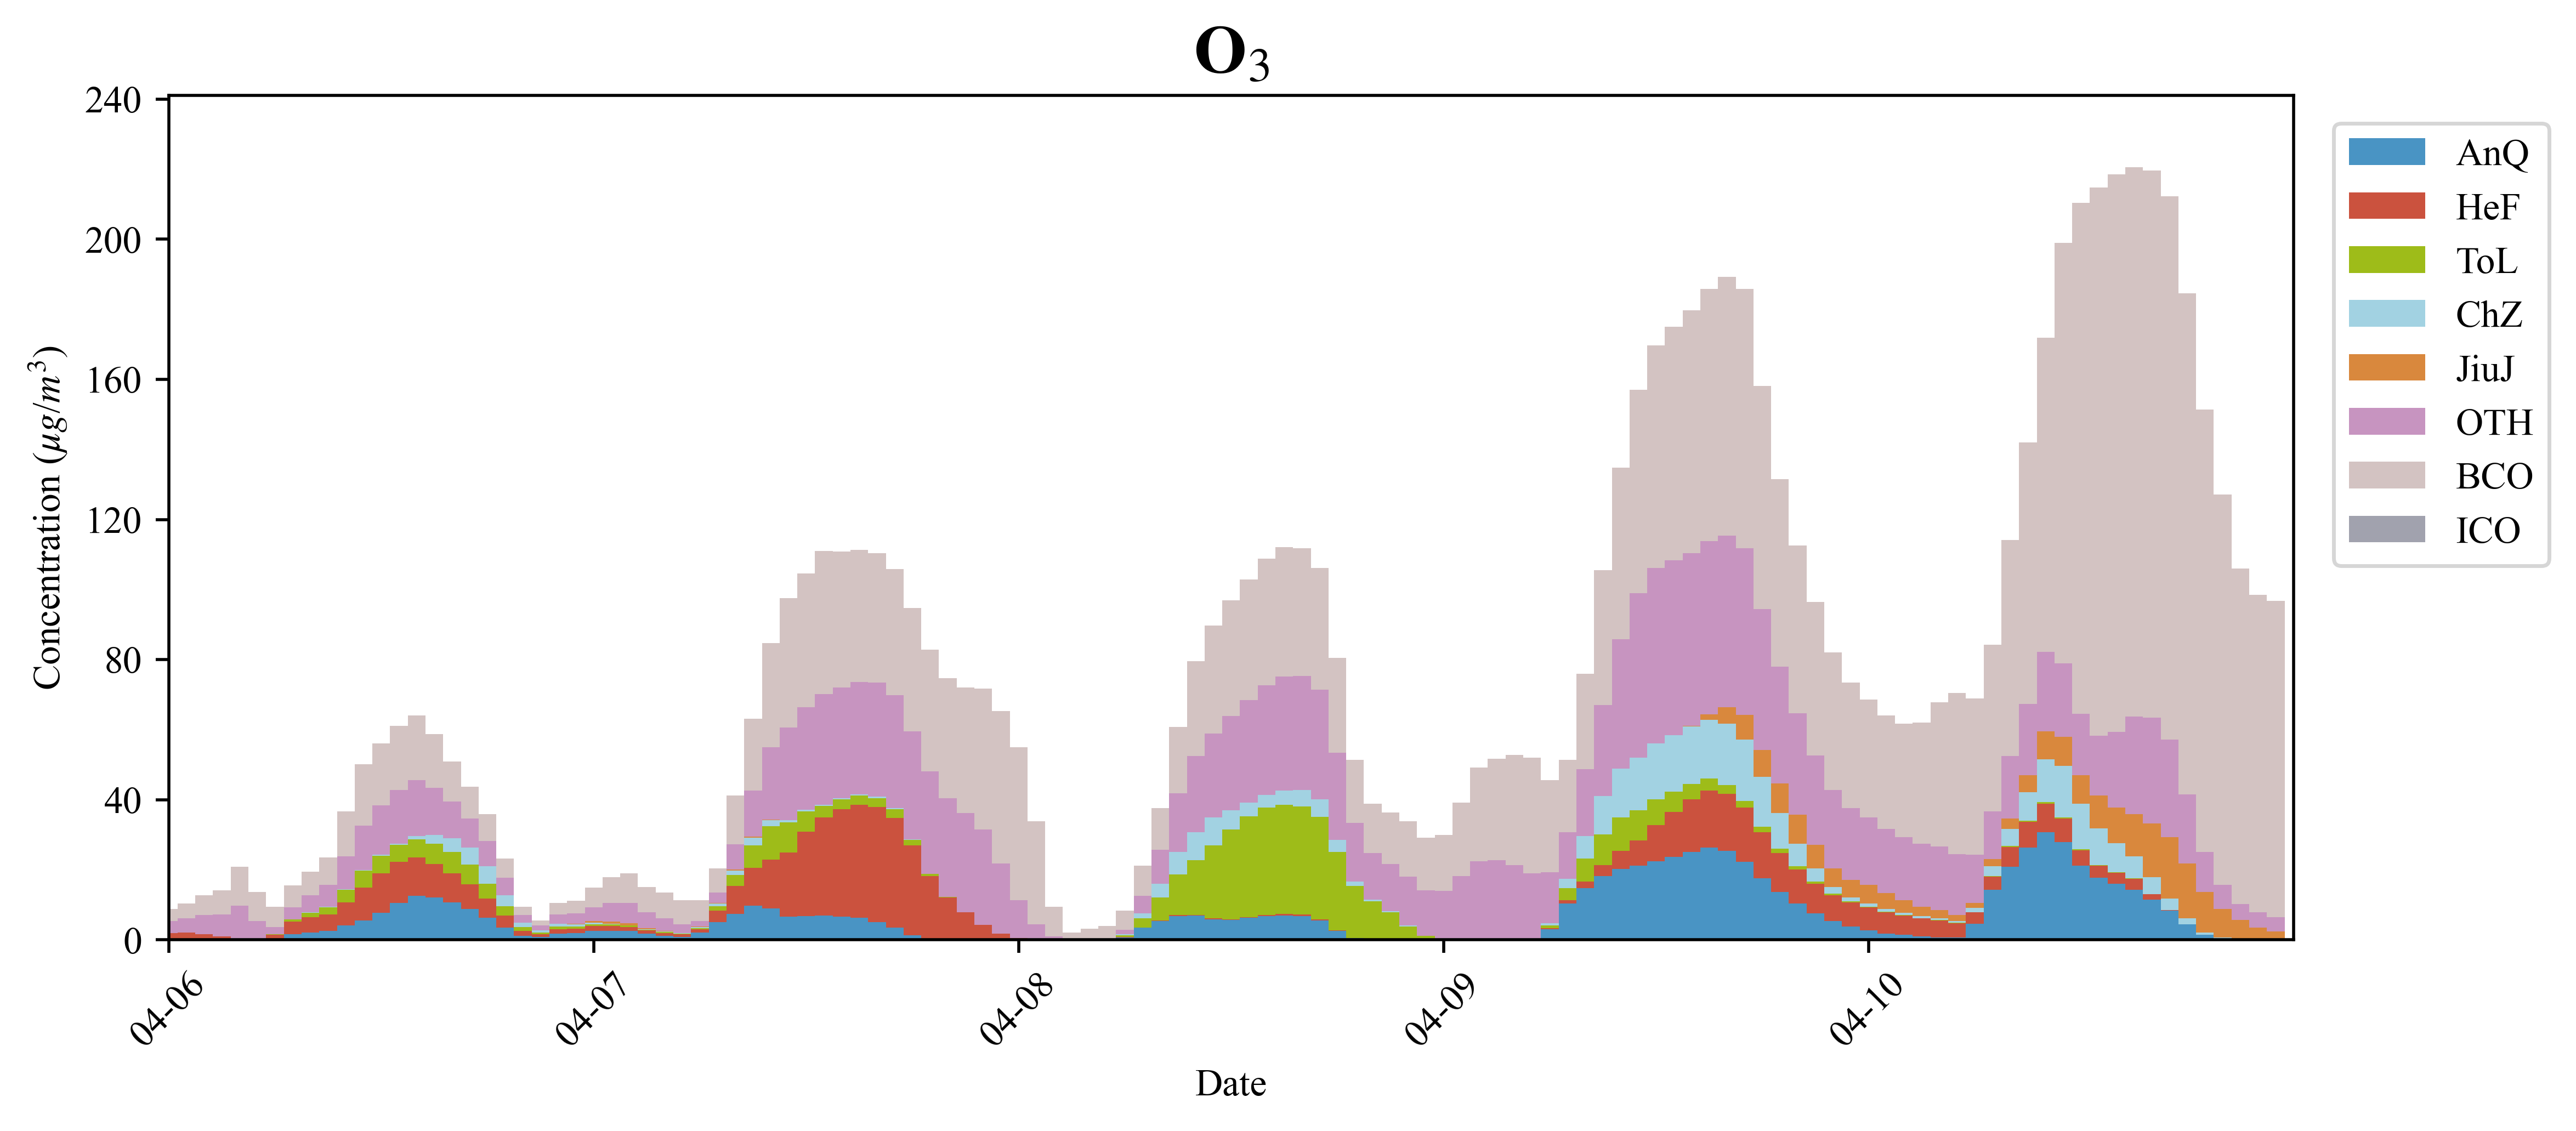

In [34]:
ts=np.arange(0,120)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,AQ_L1o,color=coloraq,width=1)
b2=ax.bar(ts,HF_L1o,bottom=AQ_L1o,color=colorhf,width=1)
b3=ax.bar(ts,TL_L1o,bottom=HF_L1o+AQ_L1o,color=colortl,width=1)
b4=ax.bar(ts,CZ_L1o,bottom=TL_L1o+HF_L1o+AQ_L1o,color=colorcz,width=1)
b5=ax.bar(ts,JJ_L1o,bottom=CZ_L1o+TL_L1o+HF_L1o+AQ_L1o,color=colorjj,width=1)
b6=ax.bar(ts,OTH_L1o,bottom=JJ_L1o+CZ_L1o+TL_L1o+HF_L1o+AQ_L1o,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,BCO_L1o,bottom=OTH_L1o+JJ_L1o+CZ_L1o+TL_L1o+HF_L1o+AQ_L1o,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ICO_L1o,bottom=BCO_L1o+OTH_L1o+JJ_L1o+CZ_L1o+TL_L1o+HF_L1o+AQ_L1o,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$',fontweight='bold',size=18)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,120,24))
ax.set_xticklabels(pd.date_range('2023-04-06','2023-04-10',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,241,40))
# ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,241)
ax.set_xlim(0,120)

plt.show()